In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


In [3]:
from src.models import FCN
from src.data_handler import DataHandler, RandomSamplingDataHandler
from src.experiment_run import Run

In [4]:
import astropy.units as u

In [5]:
torch.manual_seed(123)

In [6]:
data = np.load('data/test1.npy').T
data.shape

(2000, 10000)

In [7]:
params = pd.read_csv('data/params1.txt', sep=' ')
params = params.values
params.shape

(2000, 2)

In [8]:
dt = 50*u.yr
t_steps = 10000

# define the Universe time
u_time = np.arange(t_steps) # *dt.value

In [9]:
dt.value

50.0

In [10]:
x = torch.tensor(u_time).float().view(-1,1)
y = torch.tensor(data[0]).float().view(-1,1)

In [11]:
x.shape, y.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [12]:
nH, gamma = params[0].astype(float)

def physics_loss_fn(x, y, loss_coef=1.):
    alpha=1
    # compute dy/dx
    dy = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    
    # compute the physic loss
    ode = dy * dt.value - (1 - y) * gamma - alpha * nH * y ** 2

    return loss_coef * torch.mean(ode ** 2)

In [13]:
model = FCN([1, 32, 32, 32, 32, 32, 1], torch.nn.ELU)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=20,)

run = Run('model_for_one_set_of_params_no_physics')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(5000)

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 5000/5000 [03:54<00:00, 21.36it/s]


In [14]:
run.score()

tensor(-0.3676)

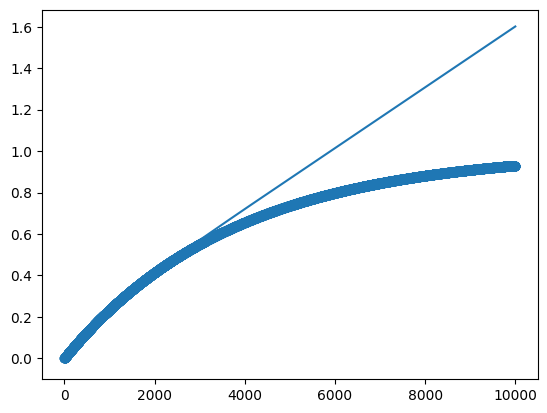

In [15]:
plt.plot(x, model(x).detach().numpy())
plt.scatter(x,y)

In [16]:
model = FCN([1, 32, 32, 32, 32, 32, 1], torch.nn.ELU)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=20,)

run = Run('model_for_one_set_of_params')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model

run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=10)

run.train(5000)

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 5000/5000 [15:14<00:00,  5.47it/s]


In [17]:
run.score()

tensor(-0.4568)

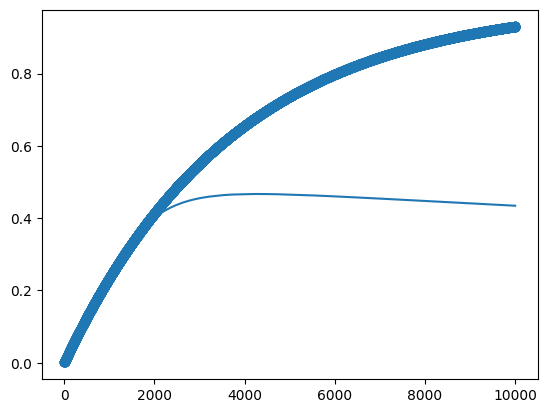

In [18]:
plt.plot(x, model(x).detach().numpy())
plt.scatter(x,y)